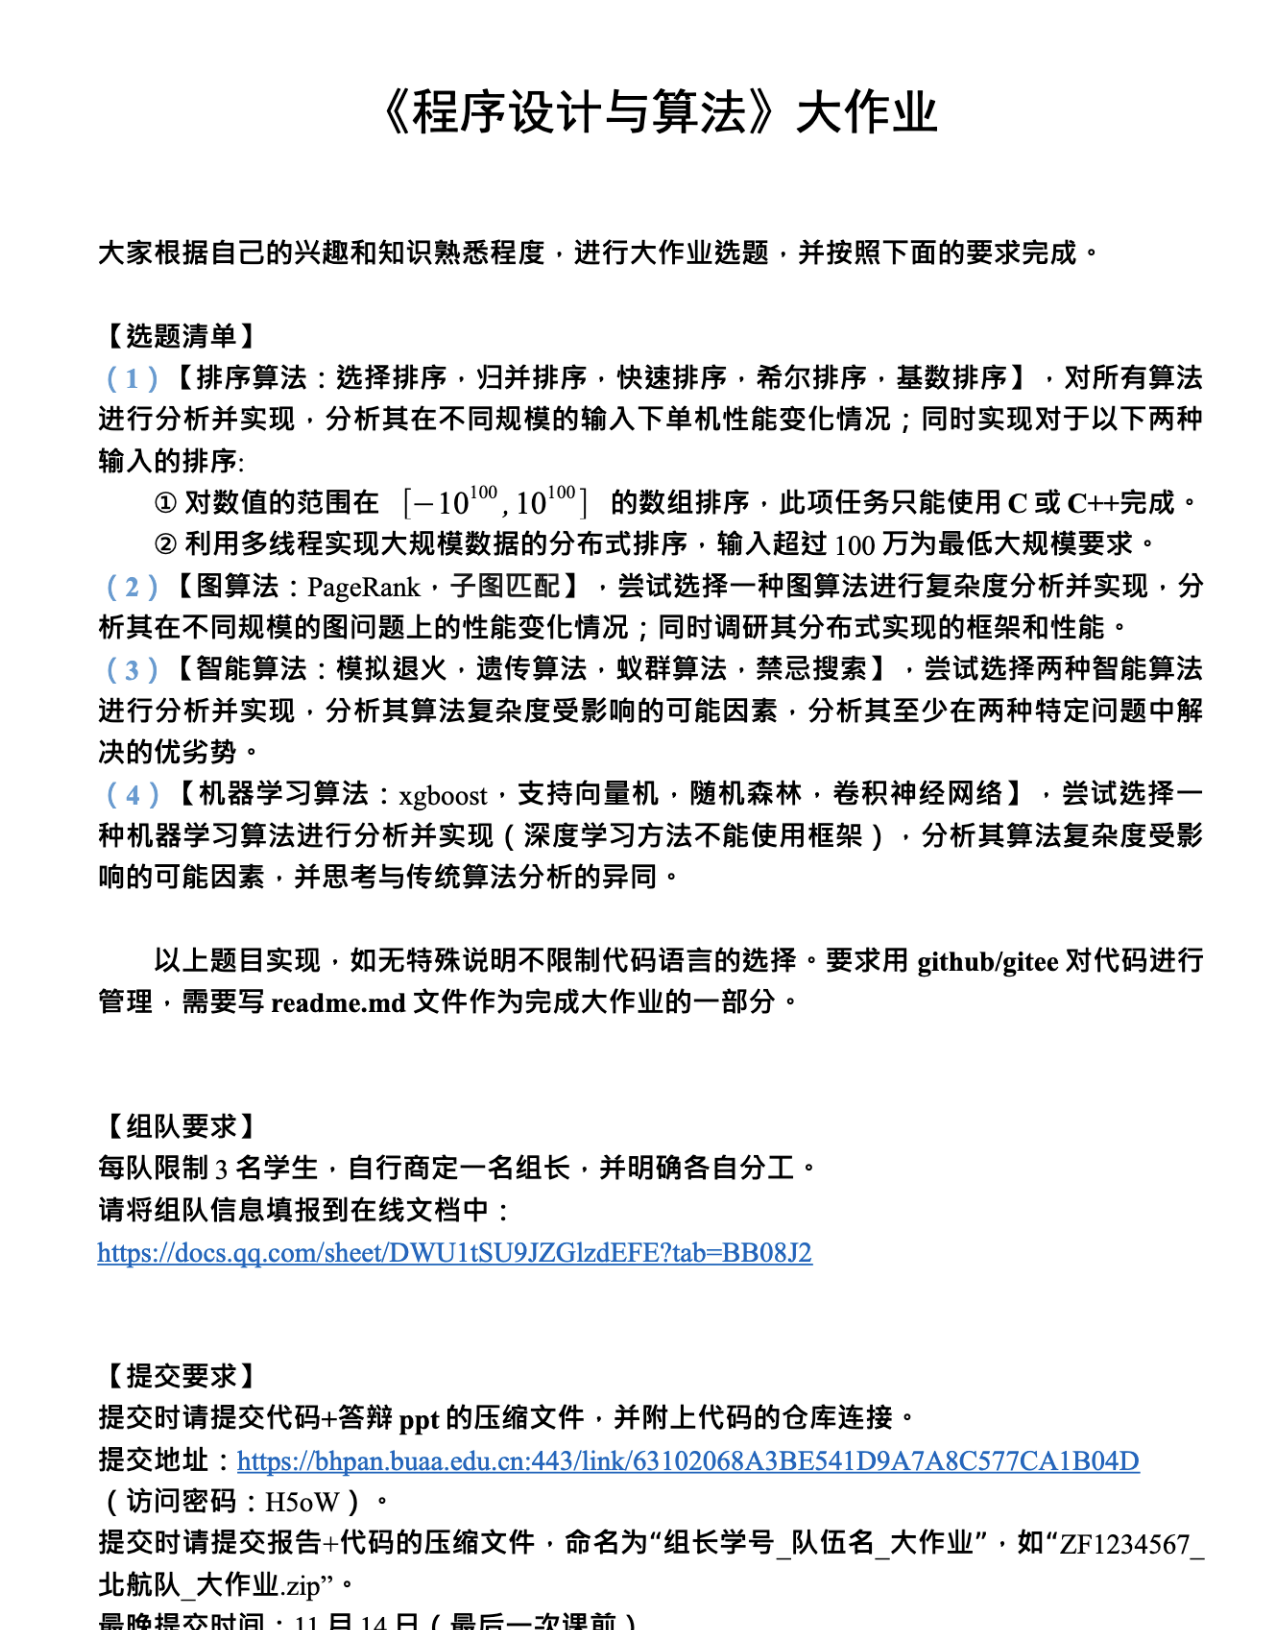

# PageRank 的简化模型

假设一共有 4 个网页 A、B、C、D。它们之间的链接信息如图所示

<img src="https://static001.geekbang.org/resource/image/81/36/814d53ff8d73113631482e71b7c53636.png?wh=1472*1007" alt="img" style="zoom:30%;" />

简单来说，一个网页的影响力 = 所有入链集合的页面的加权影响力之和，用公式表示为：

$$PR(u) =  \sum_{v \in B_u}\frac{PR(v)}{L(v)}\tag{1}$$ 


$u$为待评估的页面，$B_u$ 为页面 $u$ 的入链集合。针对入链集合中的任意页面 $v$，它能给 $u$ 带来的影响力是其自身的影响力 $PR(v)$ 除以 $v$ 页面的出链数量，即页面 $v$ 把影响力 $PR(v)$ 平均分配给了它的出链，这样统计所有能给 $u$ 带来链接的页面 $v$，得到的总和就是网页 $u$ 的影响力，即为 $PR(u)$。

分析A: A的出链是3 分别链接到了B、C、D，那么当用户访问 A 的时候，就有跳转到 B、C 或者 D 的可能性，跳转概率均为 1/3。
分析B: B 有两个出链，链接到了 A 和 D 上，跳转概率为 1/2。
以此类推，就能得出A、B、C、D 这四个网页的转移矩阵 M：
$$
M = \begin{bmatrix}
0 & 1/2 & 1 & 0 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 1/2 & 0 & 0
\end{bmatrix} \tag{2}
$$
假设 A、B、C、D 四个页面的初始影响力都是相同的，即：
$$
W_0 = \begin{bmatrix}
1/4\\
1/4\\
1/4\\
1/4
\end{bmatrix} \tag{3}
$$

当进行第一次转移之后，各页面的影响力$w_1$ 变为：
$$
w_1 = M*w0=\begin{bmatrix}
0 & 1/2 & 1 & 0 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 1/2 & 0 & 0
\end{bmatrix}  \begin{bmatrix}
1/4\\
1/4\\
1/4\\
1/4
\end{bmatrix} = \begin{bmatrix}
9/24\\
5/24\\
5/24\\
5/24
\end{bmatrix} \tag{4}
$$


In [6]:
import numpy as np
M = np.array([[0,0.5,1,0],[0.33,0,0,0.5],[0.33,0,0,0.5],[0.33,0.5,0,0]])
w0=np.array([0.25,0.25,0.25,0.25])
v=np.dot(M,w0)
print(v)

[0.375  0.2075 0.2075 0.2075]



然后我们再用转移矩阵乘以 $w_1$得到 $w_2$ 结果，直到第 $n$ 次迭代后 $w_n$ 影响力不再发生变化，可以收敛到 (0.3333，0.2222，0.2222，0.2222），也就是对应着 A、B、C、D 四个页面最终平衡状态下的影响力。

In [21]:
import numpy as np
M = np.array([[0,0.5,1,0],[1/3,0,0,0.5],[1/3,0,0,0.5],[1/3,0.5,0,0]])
w=np.array([0.25,0.25,0.25,0.25])
for i in range(1000):
    w=np.dot(M,w)
print(w)

[0.33333333 0.22222222 0.22222222 0.22222222]


能看出 A 页面相比于其他页面来说权重更大，也就是 PR 值更高。而 B、C、D 页面的 PR 值相等。

# 简化模型的局限性


## 等级泄露（Rank Leak）


如果一个网页**没有出链**，就像是一个黑洞一样，吸收了其他网页的影响力而不释放，最终会导致其他网页的 PR 值为 0。
<img src="https://static001.geekbang.org/resource/image/77/62/77336108b0233638a35bfd7450438162.png?wh=1190*997" alt="img" style="zoom:30%;" />

## 等级沉没（Rank Sink）

如果一个网页只有出链，**没有入链**（如下图所示），计算的过程迭代下来，会导致这个网页的 PR 值为 0（也就是不存在公式中的 V）。
<img src="https://static001.geekbang.org/resource/image/0d/e6/0d113854fb56116d79efe7f0e0374fe6.png?wh=1203*987" alt="img" style="zoom:30%;" />


# PageRank 的随机浏览模型

> pagerank算法就是通过你的邻居的影响力来评判你的影响力，当然然无法通过邻居来访问你，并不代表你没有影响力，因为可以直接访问你，所以引入阻尼因子的概念。现实生活中，顾客比较多的店铺质量比较好，但是要看看顾客是不是托。

为了解决简化模型中存在的等级泄露和等级沉没的问题，拉里·佩奇提出了 PageRank 的随机浏览模型。他假设了这样一个场景：用户并不都是按照跳转链接的方式来上网，还有一种可能是不论当前处于哪个页面，都有概率访问到其他任意的页面，比如说用户就是要直接输入网址访问其他页面，虽然这个概率比较小。所以他定义了**阻尼因子 d**，这个因子代表了用户按照跳转链接来上网的概率，**通常可以取一个固定值 0.85**，而 1-d=0.15 则代表了用户不是通过跳转链接的方式来访问网页的，比如直接输入网址。


$$PR(u) = \frac{1-d}{N}+ d\sum_{v \in B_u}\frac{PR(v)}{L(v)}\tag{5}$$ 

其中 N 为网页总数，这样我们又可以重新迭代网页的权重计算了，因为加入了阻尼因子 $d$，一定程度上解决了等级泄露和等级沉没的问题。

通过数学定理（这里不进行讲解）也可以证明，最终 PageRank 随机浏览模型是可以收敛的，也就是可以得到一个稳定正常的 PR 值。

# PageRank 应用

网页之间会形成一个**网络**
，是我们的互联网，论文之间也存在着相互引用的关系，可以说我们所处的环境就是各种网络的集合。**只要是有网络的地方，就存在出链和入链**，就会有 PR 权重的计算，也就可以运用我们今天讲的 PageRank 算法。

## 社交领域
在微博上，如果我们想要计算某个人的影响力，该怎么做呢？一个人的微博粉丝数并不一定等于他的实际影响力。如果按照 PageRank 算法，还需要看这些粉丝的质量如何。如果有很多明星或者大 V 关注，那么这个人的影响力一定很高。如果粉丝是通过购买僵尸粉得来的，那么即使粉丝数再多，影响力也不高。


同样，在工作场景中，比如说脉脉这个社交软件，它计算的就是个人在职场的影响力。如果你的工作关系是李开复、江南春这样的名人，那么你的职场影响力一定会很高。反之，如果你是个学生，在职场上被链入的关系比较少的话，职场影响力就会比较低。

同样，如果你想要看一个公司的经营能力，也可以看这家公司都和哪些公司有合作。如果它合作的都是世界 500 强企业，那么这个公司在行业内一定是领导者，如果这个公司的客户都是小客户，即使数量比较多，业内影响力也不一定大。

In [22]:

import networkx as nx
# 创建有向图
G = nx.DiGraph() 
# 有向图之间边的关系
edges = [("A", "B"), ("A", "C"), ("A", "D"), ("B", "A"), ("B", "D"), ("C", "A"), ("D", "B"), ("D", "C")]
for edge in edges:
    G.add_edge(edge[0], edge[1])
pagerank_list = nx.pagerank(G, alpha=1)
print("pagerank值是：", pagerank_list)

pagerank值是： {'A': 0.33333396911621094, 'B': 0.22222201029459634, 'C': 0.22222201029459634, 'D': 0.22222201029459634}


# 分布式实现pagerank
实际应用中，10亿网页组成10亿*10亿的大矩阵，肯定不是一个电脑就能计算的，分布式解决是必然的。